In [29]:
import datetime
import os
import warnings

from database import data_utils

import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

import importlib
importlib.reload(data_utils)

<module 'database.data_utils' from '/Users/zack/Desktop/valle/src/database/data_utils.py'>

In [2]:
kcm_dates, kcm_data_summaries = data_utils.full_dataset_summary("../data/kcm_all", ['tripid','file','locationtime','lat','lon','vehicleid'], "America/Los_Angeles")

In [6]:
atb_dates, atb_data_summaries = data_utils.full_dataset_summary("../data/atb_all", ['datedvehiclejourney','file','locationtime','lat','lon','vehicle'], "Europe/Oslo")

In [7]:
nwy_dates, nwy_data_summaries = data_utils.full_dataset_summary("../data/nwy_all", ['datedvehiclejourney','file','locationtime','lat','lon','vehicle'], "Europe/Oslo")

In [10]:
kcm_stats = pd.DataFrame({
    "Date": kcm_dates,
    "Observations": [x['n_points'] for x in kcm_data_summaries],
    "Trajectories": [x['n_trajs'] for x in kcm_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in kcm_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in kcm_data_summaries]
})
kcm_stats["City"] = "Seattle"
atb_stats = pd.DataFrame({
    "Date": atb_dates,
    "Observations": [x['n_points'] for x in atb_data_summaries],
    "Trajectories": [x['n_trajs'] for x in atb_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in atb_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in atb_data_summaries]
})
atb_stats["City"] = "Trondheim"
nwy_stats = pd.DataFrame({
    "Date": nwy_dates,
    "Observations": [x['n_points'] for x in nwy_data_summaries],
    "Trajectories": [x['n_trajs'] for x in nwy_data_summaries],
    "Unique Trips": [x['nunq_trips'] for x in nwy_data_summaries],
    "Unique Vehicles": [x['nunq_vehs'] for x in nwy_data_summaries]
})
nwy_stats["City"] = "Norway"
plot_data = pd.concat([kcm_stats, atb_stats, nwy_stats], axis=0)
# plot_data = pd.melt(plot_data, ["Date","City"])

In [41]:
with warnings.catch_warnings():
    # nanmean returns a warning if the array is all nan values
    warnings.simplefilter("ignore", category=RuntimeWarning)
    kcm_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in kcm_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in kcm_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in kcm_data_summaries]), axis=0, dtype="float32"))
    })
    kcm_hourly_stats["City"] = "Seattle"
    atb_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in atb_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in atb_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in atb_data_summaries]), axis=0, dtype="float32"))
    })
    atb_hourly_stats["City"] = "Trondheim"
    nwy_hourly_stats = pd.DataFrame({
        "Hour": np.arange(24, dtype="int32"),
        "Hourly Points": list(np.mean(np.array([x['hourly_points'] for x in nwy_data_summaries]), axis=0, dtype="int32")),
        "Hourly Mean Speed (m/s)": list(np.nanmean(np.array([x['hourly_mean_speeds'] for x in nwy_data_summaries]), axis=0, dtype="float32")),
        "Hourly SD Speed (m/s)": list(np.nanmean(np.array([x['hourly_sd_speeds'] for x in nwy_data_summaries]), axis=0, dtype="float32"))
    })
    nwy_hourly_stats["City"] = "Norway"
plot_data_hourly = pd.concat([kcm_hourly_stats, atb_hourly_stats, nwy_hourly_stats], axis=0).fillna(np.inf)

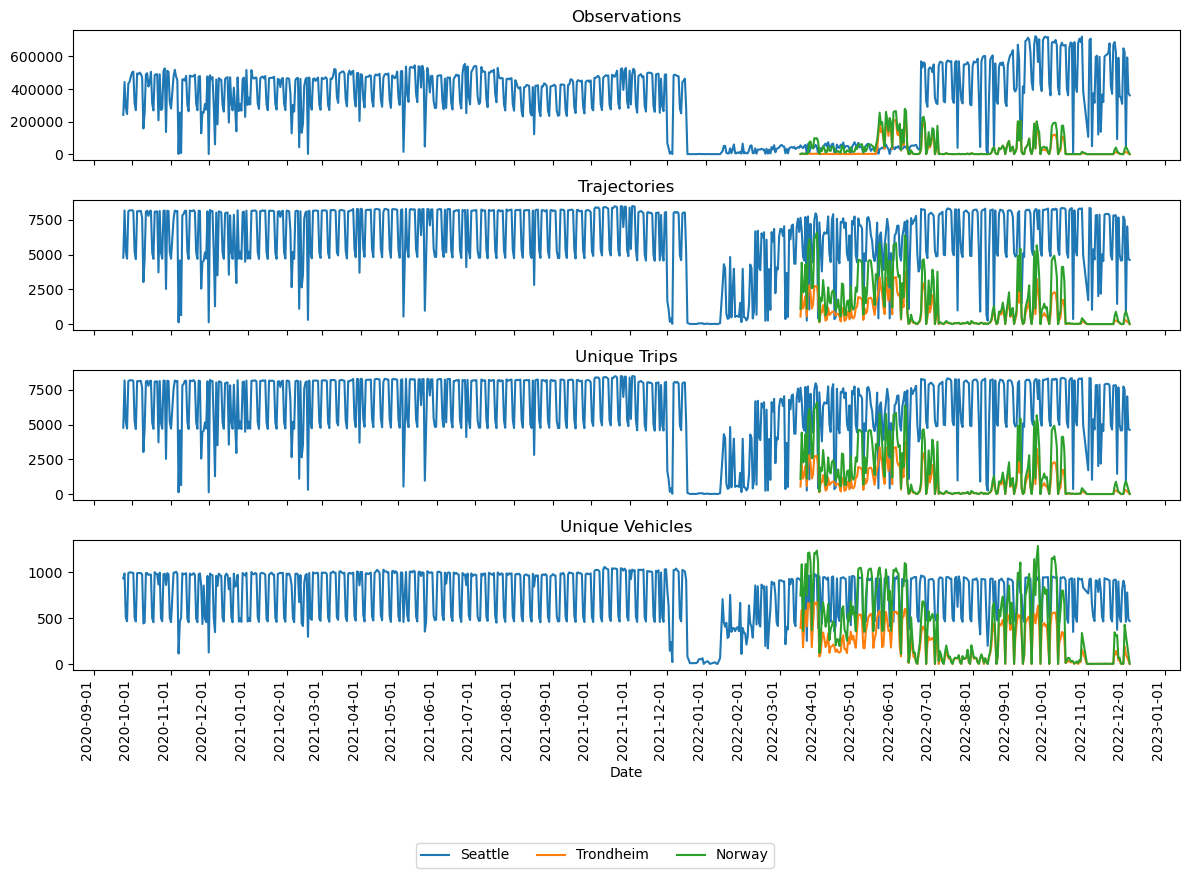

In [12]:
fig, axes = plt.subplots(4,1)
fig.set_figheight(8)
fig.set_figwidth(12)

fig.autofmt_xdate(rotation=90)
sns.lineplot(plot_data, x="Date", y="Observations", hue="City", ax=axes[0])
sns.lineplot(plot_data, x="Date", y="Trajectories", hue="City", ax=axes[1])
sns.lineplot(plot_data, x="Date", y="Unique Trips", hue="City", ax=axes[2])
sns.lineplot(plot_data, x="Date", y="Unique Vehicles", hue="City", ax=axes[3])
axes[0].set_title("Observations")
axes[1].set_title("Trajectories")
axes[2].set_title("Unique Trips")
axes[3].set_title("Unique Vehicles")
for ax in axes:
    ax.legend().set_visible(False)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
plt.figlegend(lines_labels[0][0], lines_labels[0][1], bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, labelspacing=0.)
fig.tight_layout()
plt.savefig("../plots/timeline_of_collection.png", dpi=1800, bbox_inches='tight')

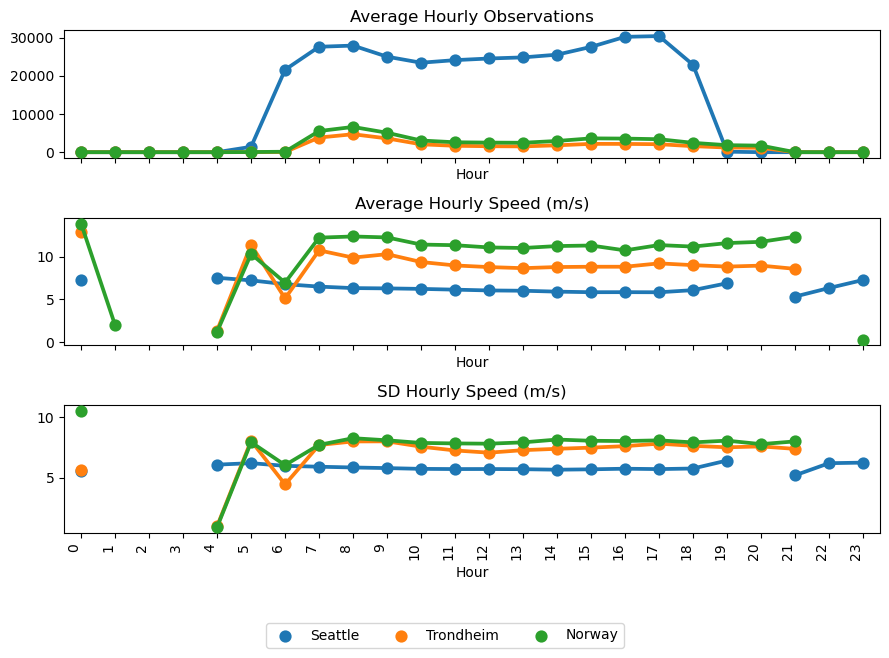

In [47]:
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(9)

fig.autofmt_xdate(rotation=90)
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly Points", hue="City", ax=axes[0])
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly Mean Speed (m/s)", hue="City", ax=axes[1], errorbar=lambda x: (x.min(), x.max()))
sns.pointplot(plot_data_hourly, x="Hour", y="Hourly SD Speed (m/s)", hue="City", ax=axes[2], errorbar=lambda x: (x.min(), x.max()))
axes[0].set_title("Average Hourly Observations")
axes[1].set_title("Average Hourly Speed (m/s)")
axes[2].set_title("SD Hourly Speed (m/s)")
for ax in axes:
    ax.legend().set_visible(False)
    ax.set_ylabel(None)
    ax.set_xticks(np.arange(24))
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
plt.figlegend(lines_labels[0][0], lines_labels[0][1], bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, labelspacing=0.)
fig.tight_layout()
plt.savefig("../plots/timeline_hourly_collection.png", dpi=1800, bbox_inches='tight')

In [48]:
# How many days are there
print(f"Number of observation days: KCM {len(kcm_dates)}, ATB {len(atb_dates)}, NWY {len(nwy_dates)}")
# How many observations are there total
print(f"Number of observed GPS points: KCM {np.sum(kcm_stats['Observations'])}, ATB {np.sum(atb_stats['Observations'])}, , NWY {np.sum(nwy_stats['Observations'])}")
# How many observations are there per day on average
kcm_per_day = int(np.sum(kcm_stats['Observations']) / len(kcm_dates))
atb_per_day = int(np.sum(atb_stats['Observations']) / len(atb_dates))
nwy_per_day = int(np.sum(nwy_stats['Observations']) / len(nwy_dates))
print(f"Number of points per day: KCM {kcm_per_day}, ATB {atb_per_day}, NWY {nwy_per_day}")
# How many points per trajectory are there on average
kcm_points_per_trip = int(np.sum(kcm_stats['Observations']) / np.sum(kcm_stats['Trajectories']))
atb_points_per_trip = int(np.sum(atb_stats['Observations']) / np.sum(atb_stats['Trajectories']))
nwy_points_per_trip = int(np.sum(nwy_stats['Observations']) / np.sum(nwy_stats['Trajectories']))
print(f"Average points per trajectory: KCM {kcm_points_per_trip}, ATB {atb_points_per_trip}, NWY {nwy_points_per_trip}")

Number of observation days: KCM 784, ATB 250, NWY 250
Number of observed GPS points: KCM 264320973, ATB 7805764, , NWY 11888874
Number of points per day: KCM 337144, ATB 31223, NWY 47555
Average points per trajectory: KCM 53, ATB 37, NWY 29


In [49]:
# Read in network shape data
with open('../data/processed_networks/kcm_segments.pkl', 'rb') as f:
    kcm_segments = pickle.load(f)
    kcm_segments = kcm_segments.to_crs('EPSG:32148')
with open('../data/processed_networks/atb_segments.pkl', 'rb') as f:
    atb_segments = pickle.load(f)
    atb_segments = atb_segments.to_crs('EPSG:25833')

In [50]:
# How much lane mileage is covered
kcm_mileage = int(np.sum(kcm_segments.length) / 1000)
atb_mileage = int(np.sum(atb_segments.length) / 1000)
print(f"Number of roadway kilometers: KCM {kcm_mileage}, ATB {atb_mileage}")
# How much area is covered
kcm_bounds = kcm_segments.bounds
kcm_area = int(((max(kcm_bounds.maxx) - min(kcm_bounds.minx)) / 1000) * ((max(kcm_bounds.maxy) - min(kcm_bounds.miny)) / 1000))
atb_bounds = atb_segments.bounds
atb_area = int(((max(atb_bounds.maxx) - min(atb_bounds.minx)) / 1000) * ((max(atb_bounds.maxy) - min(atb_bounds.miny)) / 1000))
print(f"Total network area: KCM {kcm_area}, ATB {atb_area}")

Number of roadway kilometers: KCM 3379, ATB 4679
Total network area: KCM 4175, ATB 83683
